In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

import sys

from importlib import reload

import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)s | %(name)s | %(levelname)s : %(message)s',
    level=logging.INFO,
    stream=sys.stdout
)

logger = logging.getLogger('hysped')
logger.setLevel(logging.DEBUG)

import contextily as ctx
import geocube
import geopandas as gpd
import json
import keras
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import re
import seaborn as sns
import shapely
import tensorflow as tf
import zipfile

from functools import partial
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from IPython.display import JSON, HTML
from keras.utils.np_utils import to_categorical
from matplotlib.colors import to_rgba
from shapely.geometry import box, mapping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm

# Make numpy values easier to read.
np.set_printoptions(precision=6, suppress=True)

%matplotlib inline

In [2]:
cfg = dict(
    crs = 'EPSG:5514',
    figsize = (12,12),
    data_dir = os.path.join('..', 'data'),
    data = 'sverepec_24.zip',
    data_ref = 'Sverepec_spolu.zip',
)
display(JSON(cfg))

<IPython.core.display.JSON object>

In [3]:
def split_df(df:pd.DataFrame, split:float=0.7) -> pd.DataFrame:
    rows = df.shape[0]
    at = int(split * rows)
    return df[:at], df[at:]

def nsplit_df(df:pd.DataFrame, splits:[float]=[0.7]) -> pd.DataFrame:
    rows = df.shape[0]
    df_splits = []
    beg = 0
    for split in splits:
        at = int(split * rows)
        df_splits.append(df[beg:at])
        beg = at
    df_splits.append(df[beg:])
    return df_splits

def predict_model(m, X, Y, label_encoder):
    Y_pred = m.predict(X)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_pred = label_encoder.inverse_transform(Y_pred)
    Y_pred = pd.DataFrame(Y_pred, columns=['Y_pred'])
    return Y_pred

def print_cm(ax, cm, labels, title='Confusion Matrix'):
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        ax=ax,
        cmap='Blues',
        # square=True,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=1,
        # annot_kws={'size': 12}
    )

    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

# Preprocess data

## Load

In [4]:
filename = os.path.join(cfg['data_dir'], cfg['data'])
df = pd.read_csv(filename)

display(HTML('<h2>Data preview:</h2>'))
display(df)
display(HTML('<hr>'))
display(HTML('<h2>Data statistics:</h2>'))
display(df.describe())

,Geometry,X,Y,pointid,grid_code,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,...,b473_12_10,b474_12_10,IDFULL,DATUM,POINT_X,POINT_Y,DRUH_DR,IDPL,NAZ_PL,POSKODENIE
0,Point,-467357.396,-1185629.188,7265593,0.001564,0.001564,0.001741,0.001547,0.001737,0.001705,...,-9999,-9999,24-35,12_10_2022,-467357.396,-1185629.188,SM,24,sverepec,neposkodeny
1,Point,-467357.396,-1185629.398,7269027,0.001841,0.001841,0.002274,0.002202,0.002274,0.002430,...,-9999,-9999,24-35,12_10_2022,-467357.396,-1185629.398,SM,24,sverepec,neposkodeny
2,Point,-467357.186,-1185629.398,7269028,0.002177,0.002177,0.002608,0.002603,0.002664,0.002728,...,-9999,-9999,24-35,12_10_2022,-467357.186,-1185629.398,SM,24,sverepec,neposkodeny
3,Point,-467357.396,-1185629.608,7272461,0.002373,0.002373,0.002544,0.002530,0.002706,0.002820,...,-9999,-9999,24-35,12_10_2022,-467357.396,-1185629.608,SM,24,sverepec,neposkodeny
4,Point,-467357.186,-1185629.608,7272462,0.002644,0.002644,0.003305,0.003202,0.003318,0.003066,...,-9999,-9999,24-35,12_10_2022,-467357.186,-1185629.608,SM,24,sverepec,neposkodeny
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6219,Point,-467365.376,-1185662.998,7818429,0.001723,0.001723,0.001717,0.001806,0.001756,0.002016,...,-9999,-9999,24-1,12_10_2022,-467365.376,-1185662.998,OS,24,sverepec,neposkodeny
6220,Point,-467365.166,-1185662.998,7818430,0.002050,0.002050,0.002478,0.002440,0.002405,0.002773,...,-9999,-9999,24-1,12_10_2022,-467365.166,-1185662.998,OS,24,sverepec,neposkodeny
6221,Point,-467364.956,-1185662.998,7818431,0.002680,0.002680,0.002790,0.003123,0.003634,0.003442,...,-9999,-9999,24-1,12_10_2022,-467364.956,-1185662.998,OS,24,sverepec,neposkodeny
6222,Point,-467365.166,-1185663.208,7821864,0.003241,0.003241,0.003114,0.003430,0.003580,0.003798,...,-9999,-9999,24-1,12_10_2022,-467365.166,-1185663.208,OS,24,sverepec,neposkodeny


,X,Y,pointid,grid_code,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,...,b468_12_10,b469_12_10,b470_12_10,b471_12_10,b472_12_10,b473_12_10,b474_12_10,POINT_X,POINT_Y,IDPL
count,6224.000000,6.224000e+03,6.224000e+03,6224.000000,6224.000000,6224.000000,6224.000000,6224.000000,6224.000000,6224.000000,...,6224.0,6224.0,6224.0,6224.0,6224.0,6224.0,6224.0,6224.000000,6.224000e+03,6224.0
mean,-467363.575918,-1.185647e+06,7.553752e+06,0.002145,0.002145,0.002184,0.002293,0.002411,0.002445,0.002504,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-467363.575918,-1.185647e+06,24.0
std,6.358555,8.691287e+00,1.421202e+05,0.000812,0.000812,0.000852,0.000912,0.000977,0.001003,0.001042,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.358555,8.691287e+00,0.0
min,-467380.706000,-1.185663e+06,7.265593e+06,0.000721,0.000721,0.000543,0.000620,0.000792,0.000671,0.000745,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-467380.706000,-1.185663e+06,24.0
25%,-467368.316000,-1.185654e+06,7.444158e+06,0.001482,0.001482,0.001474,0.001534,0.001591,0.001593,0.001609,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-467368.316000,-1.185654e+06,24.0
50%,-467363.906000,-1.185647e+06,7.557496e+06,0.001985,0.001985,0.002022,0.002128,0.002232,0.002257,0.002327,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-467363.906000,-1.185647e+06,24.0
75%,-467358.866000,-1.185640e+06,7.663914e+06,0.002683,0.002683,0.002756,0.002913,0.003065,0.003143,0.003229,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-467358.866000,-1.185640e+06,24.0
max,-467346.266000,-1.185629e+06,7.821865e+06,0.005156,0.005156,0.005470,0.006551,0.006178,0.006284,0.006356,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-467346.266000,-1.185629e+06,24.0


## Select columns

In [137]:
filename_ref = os.path.join(cfg['data_dir'], cfg['data_ref'])
df_ref = pd.read_csv(filename_ref, nrows=1)
select_columns = df_ref.columns
select_columns = np.append(select_columns.values, ['X', 'Y'])
df = df[select_columns]
df

,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b180_12_10,b181_12_10,b182_12_10,b183_12_10,b184_12_10,b185_12_10,b186_12_10,DRUH_DR,X,Y
0,0.001564,0.001741,0.001547,0.001737,0.001705,0.001759,0.001287,0.001678,0.001879,0.001724,...,0.007134,0.007368,0.009870,0.010213,0.010463,0.009835,0.009521,SM,-467357.396,-1185629.188
1,0.001841,0.002274,0.002202,0.002274,0.002430,0.002493,0.002303,0.002268,0.002195,0.002794,...,0.013714,0.015480,0.016433,0.016741,0.017743,0.017258,0.018021,SM,-467357.396,-1185629.398
2,0.002177,0.002608,0.002603,0.002664,0.002728,0.002763,0.002810,0.002813,0.002718,0.003199,...,0.018411,0.020122,0.020911,0.022243,0.023380,0.023042,0.024311,SM,-467357.186,-1185629.398
3,0.002373,0.002544,0.002530,0.002706,0.002820,0.002869,0.002634,0.002635,0.002570,0.003207,...,0.018398,0.020532,0.021181,0.022650,0.023085,0.023258,0.024034,SM,-467357.396,-1185629.608
4,0.002644,0.003305,0.003202,0.003318,0.003066,0.003422,0.003368,0.003382,0.003378,0.003991,...,0.027456,0.028674,0.031359,0.033472,0.034140,0.035627,0.035358,SM,-467357.186,-1185629.608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6219,0.001723,0.001717,0.001806,0.001756,0.002016,0.001626,0.001933,0.001641,0.001574,0.002202,...,0.017610,0.019562,0.020150,0.021198,0.022231,0.022791,0.024091,OS,-467365.376,-1185662.998
6220,0.002050,0.002478,0.002440,0.002405,0.002773,0.002536,0.002652,0.002565,0.002553,0.003055,...,0.021757,0.022397,0.023637,0.025067,0.025313,0.026195,0.026041,OS,-467365.166,-1185662.998
6221,0.002680,0.002790,0.003123,0.003634,0.003442,0.003587,0.003282,0.003763,0.003210,0.003760,...,0.026910,0.028104,0.031766,0.032113,0.033353,0.034763,0.034222,OS,-467364.956,-1185662.998
6222,0.003241,0.003114,0.003430,0.003580,0.003798,0.004064,0.003980,0.003832,0.003558,0.004489,...,0.027871,0.030127,0.034626,0.035700,0.037324,0.037745,0.036671,OS,-467365.166,-1185663.208


## Make geodataframe

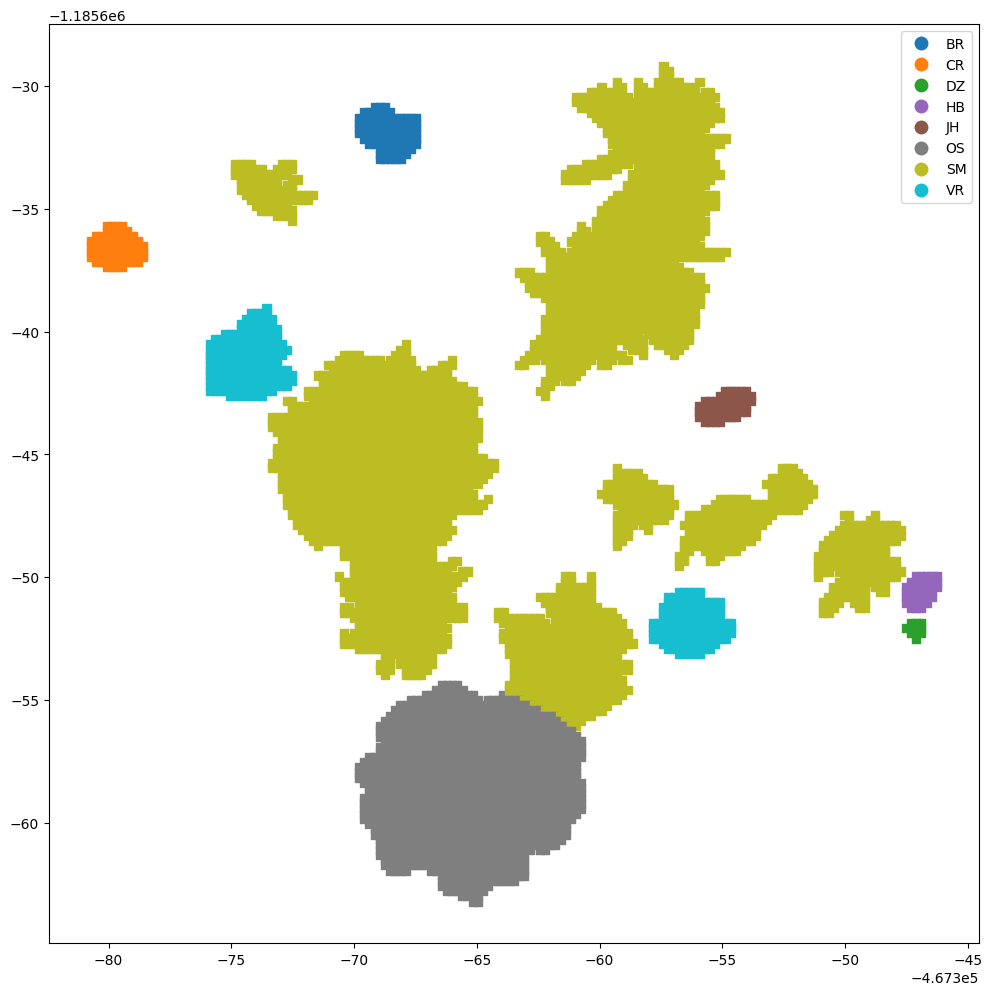

In [227]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.X, df.Y)
)
gdf = gdf.drop(columns=[gdf.X.name, gdf.Y.name])
gdf.crs = cfg['crs']

gdf.plot(column=gdf.DRUH_DR.name, legend=True, figsize=cfg['figsize'], marker=',')
plt.show()

In [7]:
gdf_sk_obce = gpd.read_file(os.path.join('..', 'maps', 'ah_shp_3.zip'), layer='obec_3')
gdf_sk_obce = gdf_sk_obce.to_crs(cfg['crs'])

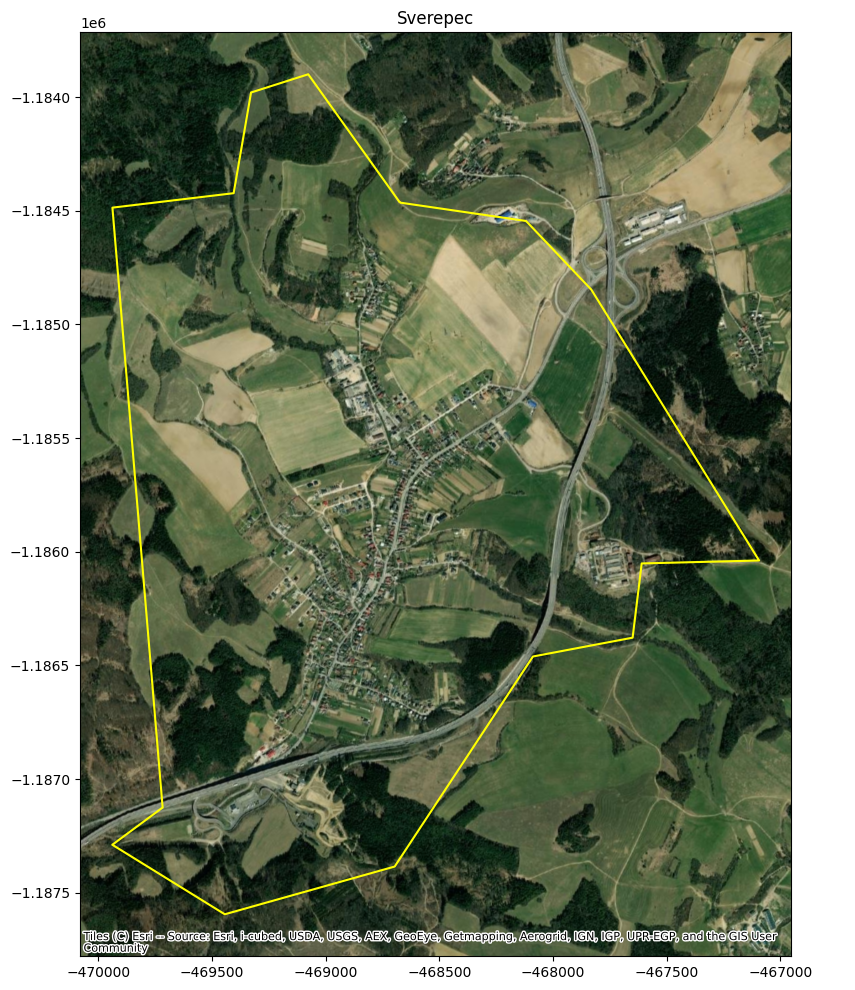

In [8]:
gdf_sverepec = gdf_sk_obce[gdf_sk_obce.NM4 == 'Sverepec']
ax = gdf_sverepec.boundary.plot(figsize=cfg['figsize'], color=to_rgba('yellow', 1.0))
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=cfg['crs'])
plt.title(gdf_sverepec.NM4.values[0])
plt.show()

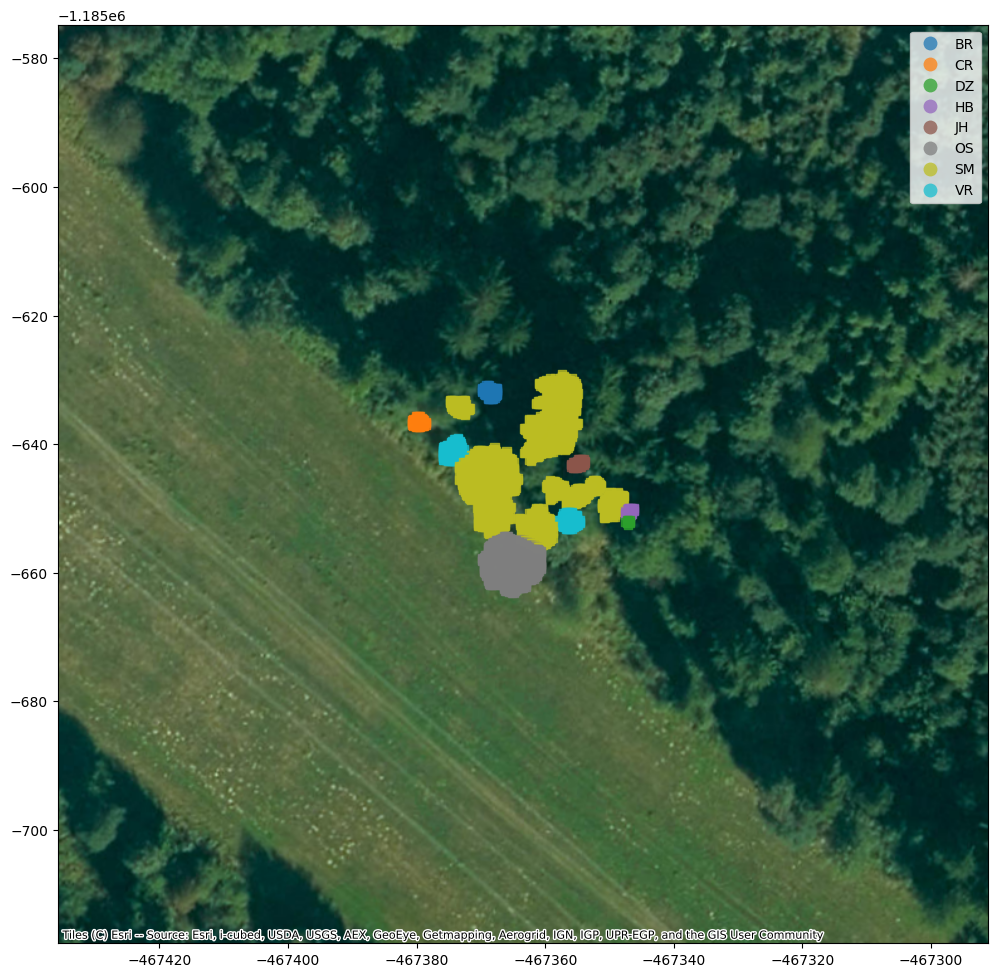

In [232]:
# select data to plot
gdf_plot = gdf[['geometry','DRUH_DR']]

# zoom out
scale = 1.6
bbox = gdf.total_bounds
dx = scale * np.abs(bbox[2]-bbox[0])
dy = scale * np.abs(bbox[3]-bbox[1])

# plot
f, ax = plt.subplots(1, figsize=cfg['figsize'])

# set boundaries
ax.set_xlim(bbox[0]-dx, bbox[2]+dx)
ax.set_ylim(bbox[1]-dy, bbox[3]+dy)

gdf_plot.plot(
    ax=ax,
    column='DRUH_DR',
    legend=True,
    alpha=0.75,
    marker=','
)

# basemap - satelite imagery
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=cfg['crs'])

plt.show()

In [10]:
print('columns (%d): %s' % (gdf.columns.shape[0], ', '.join(gdf.columns)))

columns (188): b1_12_10_2, b2_12_10_2, b3_12_10_2, b4_12_10_2, b5_12_10_2, b6_12_10_2, b7_12_10_2, b8_12_10_2, b9_12_10_2, b10_12_10_, b11_12_10_, b12_12_10_, b13_12_10_, b14_12_10_, b15_12_10_, b16_12_10_, b17_12_10_, b18_12_10_, b19_12_10_, b20_12_10_, b21_12_10_, b22_12_10_, b23_12_10_, b24_12_10_, b25_12_10_, b26_12_10_, b27_12_10_, b28_12_10_, b29_12_10_, b30_12_10_, b31_12_10_, b32_12_10_, b33_12_10_, b34_12_10_, b35_12_10_, b36_12_10_, b37_12_10_, b38_12_10_, b39_12_10_, b40_12_10_, b41_12_10_, b42_12_10_, b43_12_10_, b44_12_10_, b45_12_10_, b46_12_10_, b47_12_10_, b48_12_10_, b49_12_10_, b50_12_10_, b51_12_10_, b52_12_10_, b53_12_10_, b54_12_10_, b55_12_10_, b56_12_10_, b57_12_10_, b58_12_10_, b59_12_10_, b60_12_10_, b61_12_10_, b62_12_10_, b63_12_10_, b64_12_10_, b65_12_10_, b66_12_10_, b67_12_10_, b68_12_10_, b69_12_10_, b70_12_10_, b71_12_10_, b72_12_10_, b73_12_10_, b74_12_10_, b75_12_10_, b76_12_10_, b77_12_10_, b78_12_10_, b79_12_10_, b80_12_10_, b81_12_10_, b82_12_10_, b

## rasterize data

num_classes: 9
label_encoder.classes_: ['BR' 'CR' 'DZ' 'HB' 'JH' 'OS' 'SM' 'VR' '?']
unknown_class: 8
total_points: 6224
(x_points, y_points): (163, 161)


<xarray.Dataset>
Dimensions:      (y: 162, x: 164)
Coordinates:
  * y            (y) float64 -1.186e+06 -1.186e+06 ... -1.186e+06 -1.186e+06
  * x            (x) float64 -4.674e+05 -4.674e+05 ... -4.673e+05 -4.673e+05
    spatial_ref  int64 0
Data variables: (12/187)
    b1_12_10_2   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    b2_12_10_2   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    b3_12_10_2   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    b4_12_10_2   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    b5_12_10_2   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    b6_12_10_2   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    ...           ...
    b182_12_10   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    b183_12_10   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    b184_12_10   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    b185_12_10   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    b186_12_10   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    DRUH_DR_ENC  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

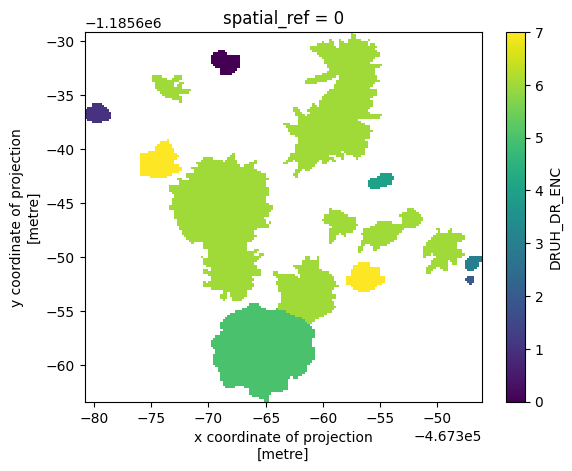

In [273]:
label_encoder = LabelEncoder()
gdf['DRUH_DR_ENC'] = label_encoder.fit_transform(gdf['DRUH_DR'])
# add another class for unknown
label_encoder.classes_ = np.concatenate((label_encoder.classes_, ['?']))
num_classes = len(label_encoder.classes_)
unknown_class = num_classes - 1
print('num_classes: %d' % num_classes)
print('label_encoder.classes_: %s' % str(label_encoder.classes_))
print('unknown_class: %s' % unknown_class)

total_points = gdf.shape[0]

bbox = gdf.total_bounds
dx = np.abs(bbox[2]-bbox[0])
dy = np.abs(bbox[3]-bbox[1])
ratio = dx/dy

# dx/dy = x_points/y_points -->
# y_points * dx = x_points * dy -->
# x_points * y_points * dx = x_points^2 * dy -->
# total_points * dx = x_points^2 * dy -->
# total_points * dx/dy = x_points^2 -->
# sqrt(total_points * ratio) = x_points

k = 4.2
x_points = np.sqrt(k * total_points * ratio)
y_points = int(np.ceil(k * total_points / x_points))
x_points = int(np.ceil(x_points))

print('total_points: %d' % total_points)
print('(x_points, y_points): %s' % str((x_points, y_points)))

geo_grid = make_geocube(
    vector_data=gdf,
    # measureme>nts=['DRUH_DR_ENC'],
    output_crs=cfg['crs'],
    resolution=(-(dy/y_points), dx/x_points),
    interpolate_na_method=None,
    rasterize_function=geocube.rasterize.rasterize_image,
)

display(geo_grid)

# mask nodata and plot
# cmap='tab20b'
# geo_grid.DRUH_DR_ENC.plot(levels=len(label_encoder.classes_))
geo_grid.DRUH_DR_ENC.plot()
plt.show()

## Add noise to NaNs and save rasterized data

In [274]:
X_keys = [k for k in geo_grid.data_vars.keys() if not re.fullmatch(r'DRUH_DR_ENC', k, flags=re.IGNORECASE)]
Y_keys = ['DRUH_DR_ENC']

mean = df[X_keys].mean().mean()
max = df[X_keys].max().max()
# noise_fn = lambda : np.random.normal(mean, 0.001)
# noise_fn = lambda : np.random.poisson(mean*1e4)/1e5
noise_fn = lambda : np.random.uniform(0.0, max)
random_label = lambda : np.random.randint(0, len(label_encoder.classes_))

def replace_nan(X, fn=noise_fn):
    for row in trange(X.shape[0], desc='replacing NaNs'):
        for col in range(X.shape[1]):
            v = X[row,col]
            if np.isnan(v).any():
                for i in range(v.shape[0]):
                    v[i] = fn()
    return X


X = geo_grid[X_keys].to_array().to_numpy().transpose([1,2,0])
Y = geo_grid[Y_keys].to_array().to_numpy().transpose([1,2,0])

X_clean = X.copy()

# replace NaNs with random data
X = replace_nan(X, fn=noise_fn)
#Y = replace_nan(Y, fn=random_label)
Y = replace_nan(Y, fn=lambda : unknown_class)

print('X: %s' % str(X.shape))
print('Y: %s' % str(Y.shape))

filename_XY = os.path.join(cfg['data_dir'], 'sverepec_24_rasterized.npz')

np.savez_compressed(
    filename_XY,
    X=X,
    Y=Y
)

loaded = np.load(filename_XY)
print(np.array_equal(X, loaded['X']))
print(np.array_equal(Y, loaded['Y']))

replacing NaNs:   0%|          | 0/162 [00:00<?, ?it/s]

replacing NaNs:   0%|          | 0/162 [00:00<?, ?it/s]

X: (162, 164, 186)
Y: (162, 164, 1)
True
True


## Show data

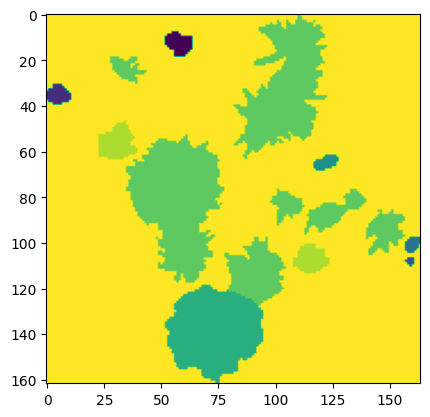

In [275]:
plt.imshow(loaded['Y'])
plt.show()

In [276]:
def flattenX(X):
    X = X[:,:][:].reshape(X.shape[0] * X.shape[1], X.shape[2])
    X = np.transpose(X, [1,0])
    return X

x = flattenX(X)
x_clean = flattenX(X_clean)

y = loaded['Y'][:,:][:].reshape(loaded['Y'].shape[0] * loaded['Y'].shape[1])

print(x.shape)
print(y.shape)

(186, 26568)
(26568,)


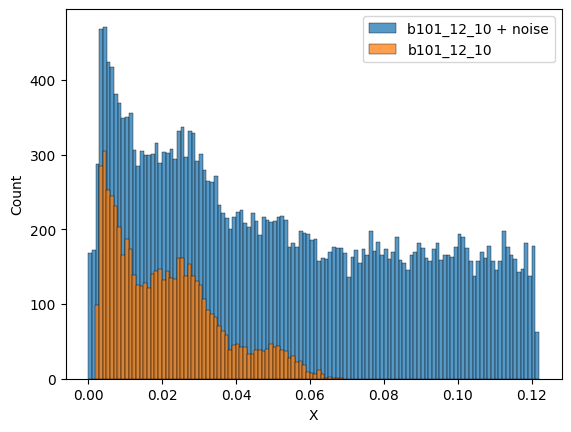

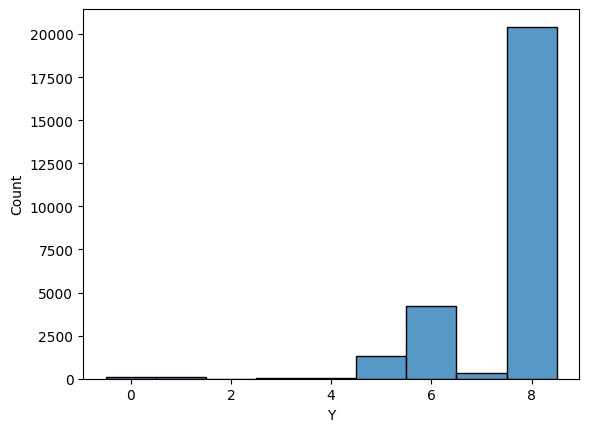

In [277]:
band = 100
sns.histplot(x[band], discrete=False, label='%s + noise' % X_keys[band], binwidth=0.001)
sns.histplot(x_clean[band], discrete=False, label='%s' % X_keys[band], binwidth=0.001)
plt.xlabel('X')
plt.legend()
plt.show()

sns.histplot(y, discrete=True)
plt.xlabel('Y')
plt.show()

## Generate sliding window data for training

In [293]:
# load rasterized data
loaded = np.load(filename_XY)
X = loaded['X']
Y = loaded['Y']
print('X: %s' % str(X.shape))
print('Y: %s' % str(Y.shape))

# define sliding window shape and window center
w_shp = (5,5)
wcx = ((w_shp[0] - 1) // 2)
wcy = ((w_shp[1] - 1) // 2)
print('w_shp: %s' % str(w_shp))
print('wcx: %s' % wcx)
print('wcy: %s' % wcy)

# sliding window over the data
swv_X = np.lib.stride_tricks.sliding_window_view(X, (*w_shp, X.shape[-1]), axis=(0,1,2))
swv_Y = np.lib.stride_tricks.sliding_window_view(Y, w_shp, axis=(0,1))
print('swv_X: %s' % str(swv_X.shape))
print('swv_Y: %s' % str(swv_Y.shape))

# reshaping sliding window X data
X_data = np.reshape(
    swv_X,
    (
        np.prod(swv_X.shape[:2]), # windows
        np.prod(w_shp),           # flattened window
        swv_X.shape[-1]           # hyperspectral data within window
    )
)
print('X_data: %s' % str(X_data.shape))

# selecting center pixels from Y sliding windows for X sliding windows and reshaping
Y_data = np.reshape(
    swv_Y[:,:,0,wcx,wcy],         # sliding window Y data center pixels
    (np.prod(swv_Y.shape[:2]), 1) # (windows, labels) -- 1 label per window
)
Y_data.shape
print('Y_data: %s' % str(Y_data.shape))

filename_XY_sliding_window = os.path.join(
    cfg['data_dir'],
    'sverepec_24_rasterized_sliding_window-%s.npz'
    %
    re.sub(r'^[^\d]*(\d+),\s*(\d+).*$', r'\1x\2', str(w_shp))
)

# save data
np.savez_compressed(
    filename_XY_sliding_window,
    X=X_data,
    Y=Y_data
)

X: (162, 164, 186)
Y: (162, 164, 1)
w_shp: (5, 5)
wcx: 2
wcy: 2
swv_X: (158, 160, 1, 5, 5, 186)
swv_Y: (158, 160, 1, 5, 5)
X_data: (25280, 25, 186)
Y_data: (25280, 1)


## Load and select sliding window data overlapping labeled data

In [294]:
# load rasterized sliding window data
loaded = np.load(filename_XY_sliding_window)
X_data = loaded['X']
Y_data = loaded['Y']
print('X_data: %s' % str(X_data.shape))
print('Y_data: %s' % str(Y_data.shape))

mask = np.apply_along_axis(lambda x: np.all(x), 1, (Y_data == unknown_class))
X_data_labeled = X_data[~mask]
Y_data_labeled = Y_data[~mask]

# 1-hot encoding
Y_data_labeled_1hot = to_categorical(Y_data_labeled, num_classes=num_classes)

print('X_data_labeled: %s' % str(X_data_labeled.shape))
print('Y_data_labeled: %s' % str(Y_data_labeled.shape))
print('Y_data_labeled_1hot: %s' % str(Y_data_labeled_1hot.shape))

X_data: (25280, 25, 186)
Y_data: (25280, 1)
X_data_labeled: (6116, 25, 186)
Y_data_labeled: (6116, 1)
Y_data_labeled_1hot: (6116, 9)


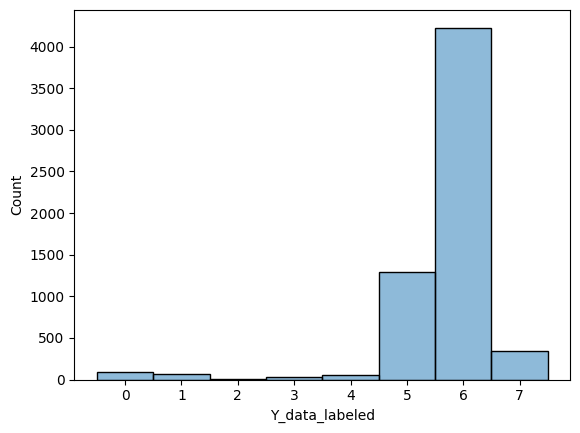

In [295]:
sns.histplot(Y_data_labeled, discrete=True, legend=False)
plt.xlabel('Y_data_labeled')
plt.show()

In [310]:
# checking data
if w_shp == (1,1):
    dfx = pd.DataFrame(X_data_labeled.reshape(np.prod(X_data_labeled.shape[:2]),186), columns=df_ref.columns[:-1])
    dfy = pd.DataFrame(label_encoder.inverse_transform(Y_data_labeled[:,0].astype(int)), columns=['DRUH_DR'])
    dfxy = pd.concat([dfx,dfy], axis=1)
    display(dfxy)
    display(df)
    gdfxy = pd.merge(dfxy, df, how='inner', on=[c for c in dfxy.columns.values])
    display(gdfxy)
    gdfxy = gpd.GeoDataFrame(gdfxy, geometry=gpd.points_from_xy(gdfxy.X, gdfxy.Y))
    gdfxy.crs = cfg['crs']
    gdfxy.plot(markersize=1)
    plt.show()

In [311]:
def make_model(input_shape, num_classes=num_classes, rescale=True): 
    featureInputLayer = tf.keras.Input(shape=input_shape)
    num_pixels = input_shape[:1][0]
    flattenLayer1 = tf.keras.layers.Flatten(data_format='channels_last')(featureInputLayer)
    rescalingLayer1 = flattenLayer1
    if rescale:
        rescalingLayer1 = tf.keras.layers.Rescaling(1.0)(flattenLayer1)
    fullyConnectedLayer1 = tf.keras.layers.Dense(num_pixels*28, name="fullyConnectedLayer1_")(rescalingLayer1)
    batchNormalizationLayer = tf.keras.layers.BatchNormalization(epsilon=0.000010, name="batchNormalizationLayer_")(fullyConnectedLayer1)
    sigmoidLayer = tf.keras.layers.Activation('sigmoid')(batchNormalizationLayer)
    dropoutLayer = tf.keras.layers.Dropout(0.150000)(sigmoidLayer)
    fullyConnectedLayer3 = tf.keras.layers.Dense(num_pixels*28, name="fullyConnectedLayer3_")(dropoutLayer)
    sigmoidLayer2 = tf.keras.layers.Activation('sigmoid')(fullyConnectedLayer3)
    fullyConnectedLayer4 = tf.keras.layers.Dense(num_classes, name="fullyConnectedLayer4_")(sigmoidLayer2)
    softmaxLayer = tf.keras.layers.Softmax()(fullyConnectedLayer4)
    classificationLayer = softmaxLayer

    model = keras.Model(inputs=[featureInputLayer], outputs=[classificationLayer])
    return model

In [314]:
model = make_model(X_data_labeled.shape[1:])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)
model.summary()

# tf.keras.utils.plot_model(
#     model,
#     expand_nested=True,
#     show_shapes=True,
#     show_layer_activations=True
# )

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 25, 186)]         0         
                                                                 
 flatten_14 (Flatten)        (None, 4650)              0         
                                                                 
 rescaling_6 (Rescaling)     (None, 4650)              0         
                                                                 
 fullyConnectedLayer1_ (Dens  (None, 700)              3255700   
 e)                                                              
                                                                 
 batchNormalizationLayer_ (B  (None, 700)              2800      
 atchNormalization)                                              
                                                                 
 activation_28 (Activation)  (None, 700)               0  

Epoch 1/100
612/612 [==============================] - 9s 13ms/step - loss: 0.6360 - categorical_accuracy: 0.8242 - val_loss: 4.7304 - val_categorical_accuracy: 0.3466
Epoch 2/100
612/612 [==============================] - 8s 13ms/step - loss: 0.5303 - categorical_accuracy: 0.8438 - val_loss: 4.8408 - val_categorical_accuracy: 0.4561
Epoch 3/100
612/612 [==============================] - 8s 13ms/step - loss: 0.4859 - categorical_accuracy: 0.8459 - val_loss: 4.7624 - val_categorical_accuracy: 0.5659
Epoch 4/100
612/612 [==============================] - 8s 13ms/step - loss: 0.4671 - categorical_accuracy: 0.8565 - val_loss: 5.3844 - val_categorical_accuracy: 0.4471
Epoch 5/100
612/612 [==============================] - 8s 13ms/step - loss: 0.4457 - categorical_accuracy: 0.8655 - val_loss: 5.3699 - val_categorical_accuracy: 0.4918
Epoch 6/100
612/612 [==============================] - 8s 13ms/step - loss: 0.4205 - categorical_accuracy: 0.8729 - val_loss: 6.2620 - val_categorical_accuracy:

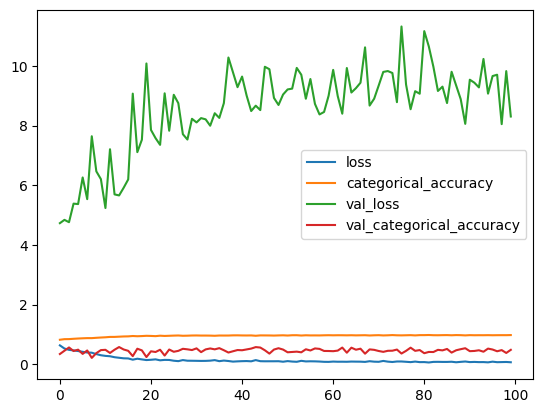

In [315]:
history = model.fit(
    X_data_labeled,
    Y_data_labeled_1hot,
    epochs=100,
    validation_split=0.6,
    shuffle=True,
    batch_size=4
)

for k in history.history.keys():
    plt.plot(history.history[k], label=k)
plt.legend()
plt.show()

In [ ]:
Y_true_labeled = label_encoder.inverse_transform(Y_data_labeled[:,0].astype(int))
Y_pred_labeled = predict_model(model, X_data_labeled, Y_data_labeled_1hot, label_encoder=label_encoder)
cm = confusion_matrix(Y_true_labeled, Y_pred_labeled)

fig, ax = plt.subplots(figsize=(9,5))
print_cm(ax, cm, labels=label_encoder.classes_)
plt.show()